## Outline for A/B Tests
* Set up the experiment.
* Run the test and record the success rate for each group.
* Plot the distribution of the difference between the two samples.
* Calculate the statistical power.
* Evaluate how sample size affects A/B tests.

Before running the test, we will know the baseline conversion rate and the desired lift or increase in signups that we would like to test. The baseline conversion rate is the current rate at which we sign up new users under the existing design. For our example, we want to use our test to confirm that the changes we make to our signup process will result in at least a 2% increase in our sign up rate. We currently sign up 10 out of 100 users who are offered a premium account

In [37]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs

# import custom scripts
from plot import *
from data import *
from stats import *

%matplotlib inline
plt.style.use('ggplot')
# %autoreload

In [1]:
bcr = 0.10  # baseline conversion rate
d_hat = 0.02  # difference between the groups

## Control Group (A) and Test Group (B)

Typically, the total number of users participating in the A/B test make up a small percentage of the total amount of users. Users are randomly selected and assigned to either a control group or a test group. The sample size that you decide on will determine how long you might have to wait until you have collected enough. For example, websites with large audiences may be able to collect enough data very quickly, while other websites may have to wait a number of weeks. There are some events that happen rarely even for high-traffic websites, so determining the necessary sample size will inform how soon you can assess your experiment and move on to improving other metrics.

Initially, we will collect 1000 users for each group and serve the current signup page to the control group and a new signup page to the test group.

In [2]:
# A is control; B is test
N_A = 1000
N_B = 1000

## 2. Run the Test

Because this is a hypothetical example, we will need “fake” data to work on. I wrote a function that will generate data for our simulation.

In [18]:
from data import generate_data
import numpy as np
import pandas as pd
ab_data = generate_data(N_A, N_B, bcr, d_hat)

In [19]:
print(ab_data.head())
print(ab_data.shape)

   converted group
0          0     B
1          0     B
2          0     B
3          0     A
4          0     B
(2000, 2)


The generate_data function returned the table on the left. Only the first five rows are shown. The converted column indicates whether a user signed up for the premium service or not with a 1 or 0, respectively. The A group will be used for our control group and the B group will be our test group

Let’s look at a summary of the results using the pivot table function in Pandas.

In [26]:
A_group = ab_data[ab_data['group'] == 'A']
B_group = ab_data[ab_data['group'] == 'B']

In [27]:
A_converted, B_converted = A_group['converted'].sum(), B_group['converted'].sum()
A_converted, B_converted

(80, 23)

In [28]:
A_total, B_total = len(A_group), len(B_group)
A_total, B_total

(1014, 986)

In [29]:
p_A, p_B = A_converted / A_total, B_converted / B_total
p_A, p_B

(0.07889546351084813, 0.02332657200811359)

In [30]:
p_B - p_A

-0.05556889150273454

In [32]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')
print(ab_summary)

       converted  total      rate
group                            
A             80   1014  0.078895
B             23    986  0.023327


It looks like the difference in conversion rates between the two groups is 0.028 which is greater than the lift we initially wanted of 0.02. This is a good sign but this is not enough evidence for us to confidently go with the new design. At this point we have not measured how confident we are in this result. This can be mitigated by looking at the distributions of the two groups.

## 3. Compare the Two Groups  
We can compare the two groups by plotting the distribution of the control group and calculating the probability of getting the result from our test group. We can assume that the distribution for our control group is binomial because the data is a series of Bernoulli trials, where each trial only has two possible outcomes (similar to a coin flip)

Text(0,0.5,'probability')

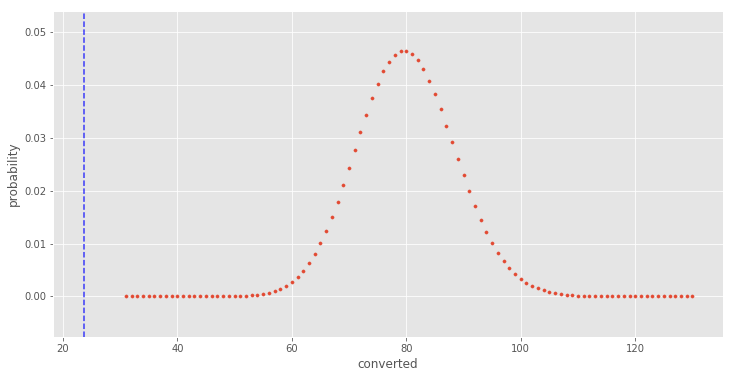

In [38]:
from plot import plt
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, p_A).pmf(x)
ax.scatter(x, y, s=10)
ax.axvline(x=p_B * A_total, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')

The distribution for the control group is shown in red and the result from the test group is indicated by the blue dashed line. We can see that the probability of getting the result from the test group was very low. However, the probability does not convey the confidence level of the results. It does not take the sample size of our test group into consideration. Intuitively, we would feel more confident in our results as our sample sizes grow larger. Let’s continue and plot the test group results as a binomial distribution and compare the distributions against each other.

Text(0,0.5,'probability')

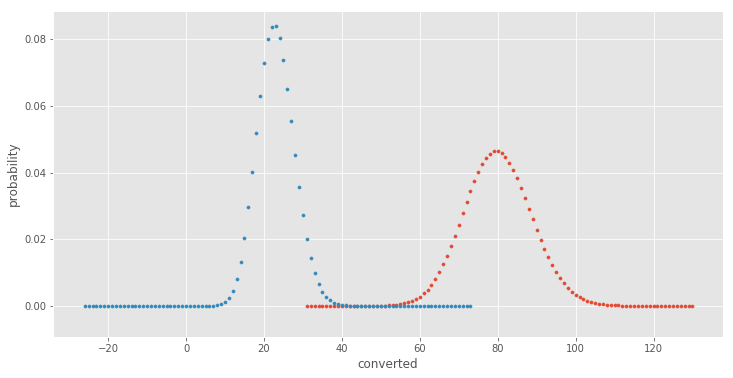

In [39]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total, p_A).pmf(xA)
ax.scatter(xA, yA, s=10)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total, p_B).pmf(xB)
ax.scatter(xB, yB, s=10)
plt.xlabel('converted')
plt.ylabel('probability')

We can see that the test group converted more users than the control group. We can also see that the peak of the test group results is lower than the control group. How do we interpret the difference in peak probability? We should focus instead on the conversion rate so that we have an apples-to-apples comparison. In order to calculate this, we need to standardize the data and compare the probability of successes, p, for each group.

# Bernoulli Distribution and the Central Limit Theorem
To do this, first, consider the Bernoulli distribution for the control group.  
X ~ Bernoulli(p)  
where p is the conversion probability of the control group.  

According to the properties of the Bernoulli distribution, the mean and variance are as follows:

Text(0,0.5,'PDF')

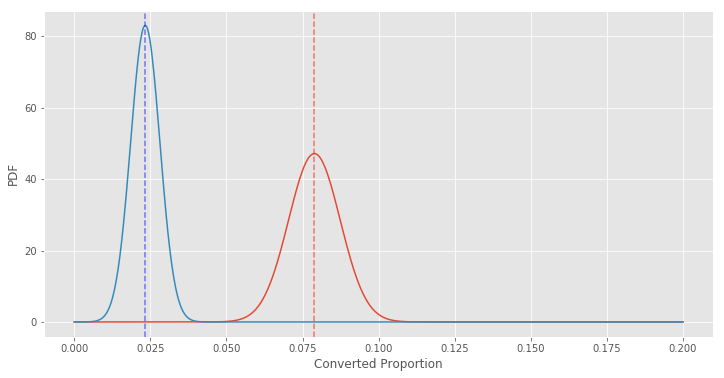

In [41]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(0, .2, 1000)
yA = scs.norm(p_A, SE_A).pdf(xA)
ax.plot(xA, yA)
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')

xB = np.linspace(0, .2, 1000)
yB = scs.norm(p_B, SE_B).pdf(xB)
ax.plot(xB, yB)
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')

plt.xlabel('Converted Proportion')
plt.ylabel('PDF')

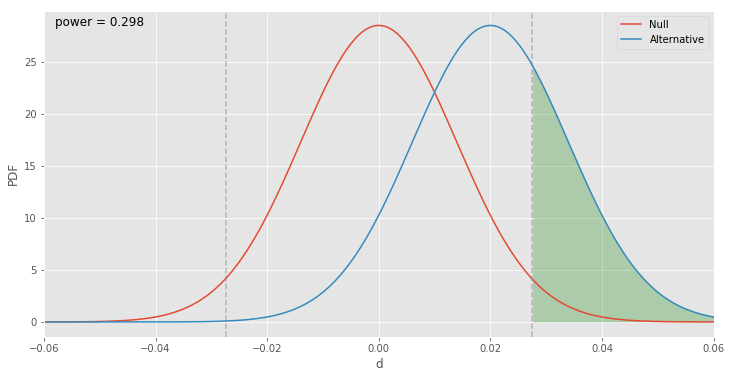

In [42]:
abplot(N_A, N_B, bcr, d_hat, show_power=True)

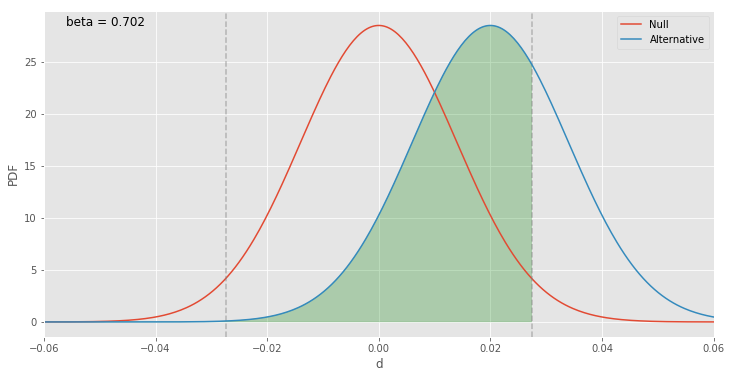

In [43]:

abplot(N_A, N_B, bcr, d_hat, show_beta=True)

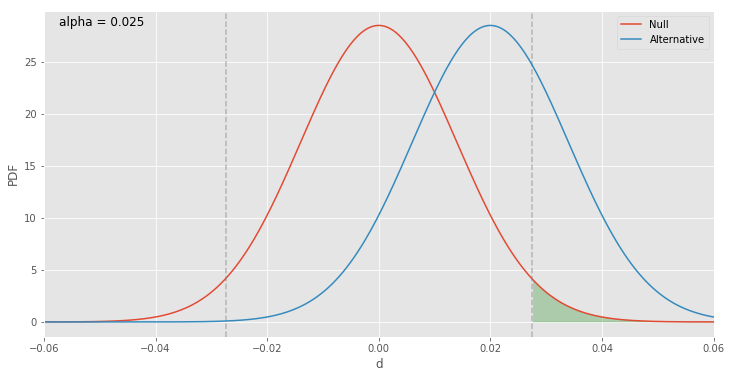

In [44]:
abplot(N_A, N_B, bcr, d_hat, show_alpha=True)

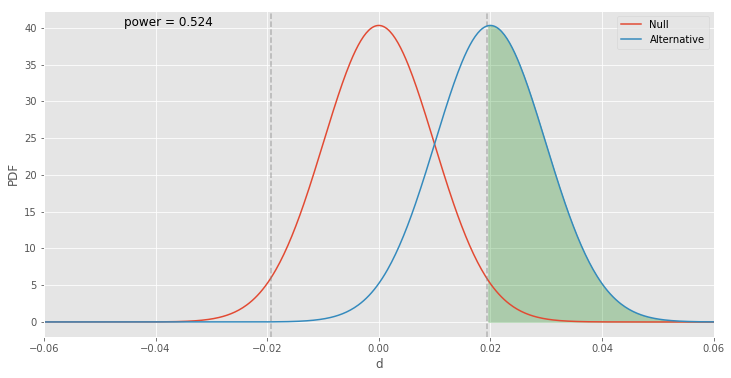

In [45]:
abplot(2000, 2000, bcr, d_hat, show_power=True)

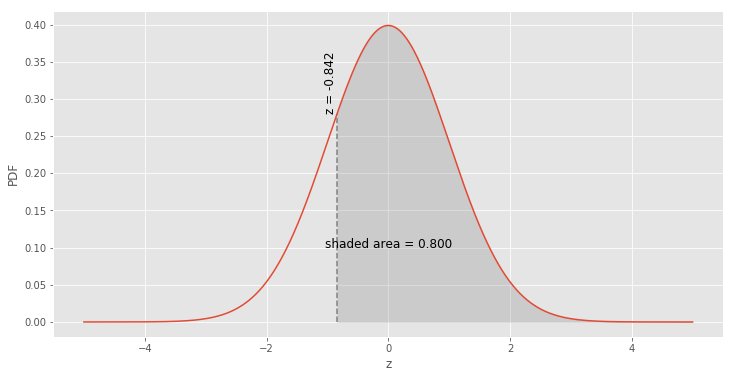

In [46]:
zplot(area=0.80, two_tailed=False, align_right=True)

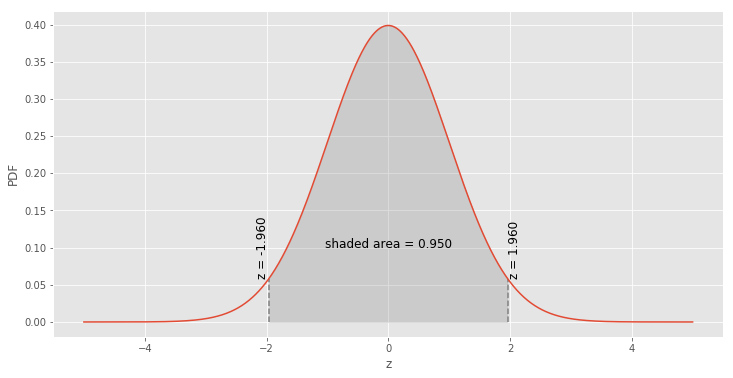

In [47]:
zplot(area=0.95, two_tailed=True)

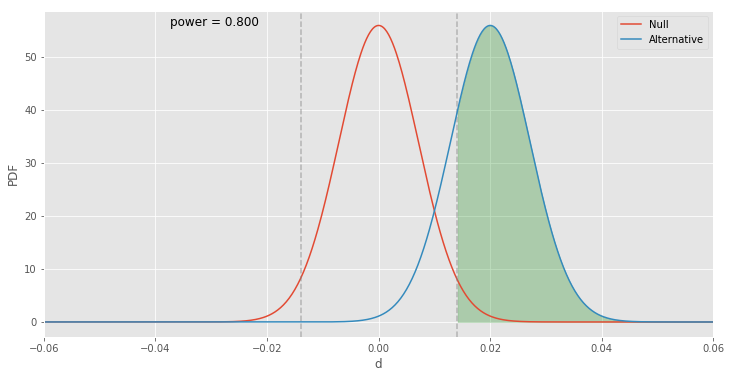

In [48]:
abplot(3843, 3843, 0.10, 0.02, show_power=True)

# Increase the Sample Size

In [50]:
# parameters for generate_data()
N_A = 6000
N_B = 6000
p_A=0.10
p_B=0.12

In [51]:
ab_data = generate_data(N_A, N_B, p_A, p_B)

In [52]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')
ab_summary

,converted,total,rate
group,,,
A,617,6083,0.101430
B,749,5917,0.126584


In [53]:
# parameters for abplot
n = N_A + N_B
p_A_actual = ab_summary.loc['A', 'rate']
p_B_actual = ab_summary.loc['B', 'rate']
bcr = p_A_actual
d_hat = p_B_actual - p_A_actual

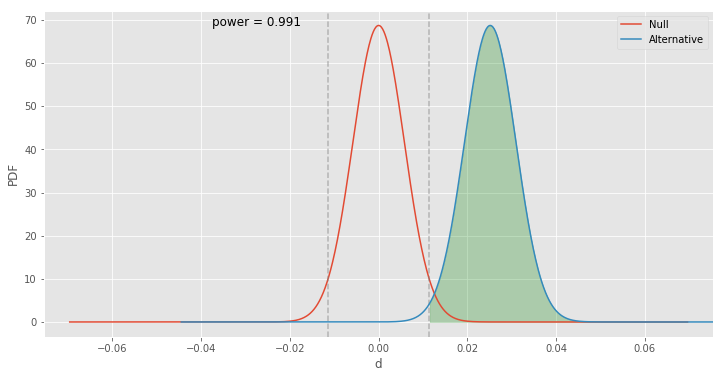

In [54]:
abplot(N_A, N_B, bcr, d_hat, show_power=True)

# Multiple Tests and Funnel Tests

# Confidence Interval Plot

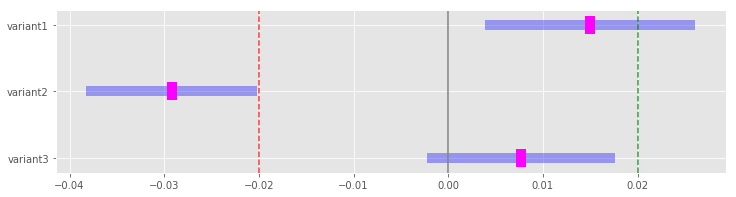

In [55]:
abplot_CI_bars((6000, 6000, 8900, 9100), (600, 690, 630, 980), sig_level=0.05, dmin=0.02)

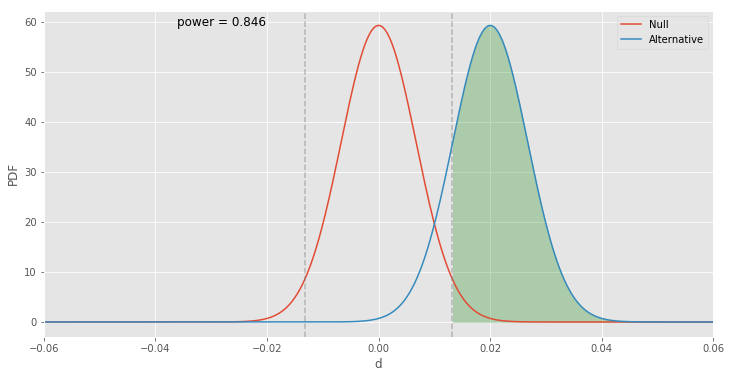

In [56]:
abplot(3000, 9100, 0.10, 0.02, show_power=True)

In [57]:
A = [(10000, 2000), (2000, 200), (300, 40)]
B = [(10000, 2200), (2000, 240), (300, 25)]

[ 0.02  0.02 -0.05]


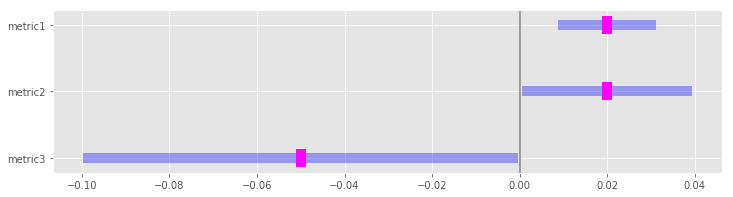

In [58]:
funnel_CI_plot(A, B, sig_level=0.05)

### Used Links
https://github.com/mnguyenngo/ab-framework  
https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f
    